In [ ]:
!pip install torch torchvision matplotlib Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 9.4 MB/s eta 0:00:00


In [ ]:
!pip install tensorboard

In [ ]:
import torch
import json
from torch.utils.data import DataLoader
from torchvision.datasets import VOCDetection
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import boto3
import io
import pickle

The just above cell have been deleated because It contained my aws cretentials  
It looked like   
os.environ['AWS_ACCESS_KEY_ID'] = '....'  
os.environ['AWS_SECRET_ACCESS_KEY'] = '...'  
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'

In [ ]:
bucket_name = 'cardetection01'

In [ ]:
class VOCCarDataset(Dataset):
    def __init__(self, root, year='2007', image_set=None, download=True, transforms=None):
        if image_set=='train' :
            image_set = 'train'
        elif image_set=='val' :
            image_set = 'val'
        else :
            image_set = 'test'
        self.voc = VOCDetection(root=root, year=year, image_set=image_set, download=download)
        self.transforms = transforms
        self.class_to_idx = {'car': 1}

    def __len__(self):
        return len(self.voc)

    def __getitem__(self, idx):
        img, annotation = self.voc[idx]
        annotation = annotation['annotation']

        boxes = []
        labels = []

        # Handle cases where there are no objects at all
        if 'object' not in annotation or annotation['object'] is None:
             # Ensure empty boxes tensor has correct shape [0, 4]
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
            labels_tensor = torch.zeros((0,), dtype=torch.int64)
            return img, {
                'boxes': boxes_tensor,
                'labels': labels_tensor,
                'image_id': torch.tensor([idx])
            }


        objects = annotation['object']
        if not isinstance(objects, list):
            objects = [objects]

        for obj in objects:
            name = obj['name']
            if name != 'car':
                continue

            bndbox = obj['bndbox']
            xmin = float(bndbox['xmin'])
            ymin = float(bndbox['ymin'])
            xmax = float(bndbox['xmax'])
            ymax = float(bndbox['ymax'])

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.class_to_idx['car'])

        if not boxes:
             # If no car objects were found, create an empty tensor with shape [0, 4]
            boxes_tensor = torch.zeros((0, 4), dtype=torch.float32)
        else:
            boxes_tensor = torch.tensor(boxes, dtype=torch.float32)

        labels_tensor = torch.tensor(labels, dtype=torch.int64)


        target = {


            'boxes': boxes_tensor,
            'labels': labels_tensor,
            'image_id': torch.tensor([idx])
        }

        if self.transforms:
            img = self.transforms(img)

        return img, target

In [ ]:
from torchvision.transforms import functional as F
import random

def get_transform(train):
    def apply_transforms(image):
        image = F.to_tensor(image)
        if train and random.random() > 0.5:
            image = F.hflip(image)
        return image
    return apply_transforms


def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
def train_model(model, device, train_loader, num_epochs=None, num_classes=2):
    model.to(device)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    model.train()
    writer = SummaryWriter(log_dir="runs/fasterrcnn_car_detector")

    # Dictionary to store loss logs
    loss_history = {
        'epoch': [],
        'total_loss': [],
        'loss_classifier': [],
        'loss_box_reg': [],
        'loss_objectness': [],
        'loss_rpn_box_reg': [],
    }

    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        epoch_loss = 0.0
        epoch_cls_loss = 0.0
        epoch_box_loss = 0.0
        epoch_obj_loss = 0.0
        epoch_rpn_loss = 0.0

        for images, targets in tqdm(train_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            total_loss = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            epoch_loss += total_loss.item()
            epoch_cls_loss += loss_dict['loss_classifier'].item()
            epoch_box_loss += loss_dict['loss_box_reg'].item()
            epoch_obj_loss += loss_dict['loss_objectness'].item()
            epoch_rpn_loss += loss_dict['loss_rpn_box_reg'].item()

        # Log to TensorBoard
        writer.add_scalar("Loss/Total", epoch_loss, epoch)
        writer.add_scalars("Loss/Components", {
            'classifier': epoch_cls_loss,
            'box_reg': epoch_box_loss,
            'objectness': epoch_obj_loss,
            'rpn_box_reg': epoch_rpn_loss,
        }, epoch)

        # Save in dictionary
        loss_history['epoch'].append(epoch + 1)
        loss_history['total_loss'].append(epoch_loss)
        loss_history['loss_classifier'].append(epoch_cls_loss)
        loss_history['loss_box_reg'].append(epoch_box_loss)
        loss_history['loss_objectness'].append(epoch_obj_loss)
        loss_history['loss_rpn_box_reg'].append(epoch_rpn_loss)

        print(f"Epoch Loss: {epoch_loss:.4f}")

    writer.close()
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer)
    buffer.seek(0)
    s3 = boto3.client('s3')
    object_key = "models/car_detector.pth"
    s3.upload_fileobj(buffer, bucket_name, object_key)

    print(f"Model uploaded to s3://{bucket_name}/{object_key}")

    return loss_history

In [ ]:
def save_loss_history_to_s3(loss_history, bucket_name, object_key="models/loss_history.pkl"):
    buffer = io.BytesIO()
    pickle.dump(loss_history, buffer)
    buffer.seek(0)
    s3 = boto3.client('s3')
    s3.upload_fileobj(buffer, bucket_name, object_key)

    print(f"Loss history uploaded to s3://{bucket_name}/{object_key}")

In [ ]:
train_dataset = VOCCarDataset(root='data', image_set='train', download=True, transforms=get_transform(train=True))
val_dataset = VOCCarDataset(root='data', image_set='val', download=True, transforms=get_transform(train=False))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_dataset = VOCCarDataset(root='data', image_set='test', download=True, transforms=get_transform(train=False))

test_loader = DataLoader(train_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
model = get_model(num_classes= 2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_history = train_model(model, device, train_loader, num_epochs=5)



100%|██████████| 460M/460M [00:17<00:00, 26.7MB/s]
100%|██████████| 451M/451M [00:18<00:00, 25.0MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 74.5MB/s]


Epoch [1/5]


100%|██████████| 626/626 [13:35<00:00,  1.30s/it]


Epoch Loss: 36.1457
Epoch [2/5]


100%|██████████| 626/626 [13:38<00:00,  1.31s/it]


Epoch Loss: 28.1995
Epoch [3/5]


100%|██████████| 626/626 [13:38<00:00,  1.31s/it]


Epoch Loss: 27.0224
Epoch [4/5]


100%|██████████| 626/626 [13:42<00:00,  1.31s/it]


Epoch Loss: 27.5220
Epoch [5/5]


100%|██████████| 626/626 [13:40<00:00,  1.31s/it]


Epoch Loss: 24.8211
Model uploaded to s3://cardetection01/models/car_detector.pth
Loss history uploaded to s3://cardetection01/model_training/loss_history.pkl


In [ ]:
save_loss_history_to_s3(loss_history, bucket_name)

Loss history uploaded to s3://cardetection01/models/loss_history.pkl


In [ ]:
def download_model_from_s3(bucket_name, model_key, local_path="car_detector.pth"):
    s3 = boto3.client('s3')
    s3.download_file(bucket_name, model_key, local_path)
    return local_path

def predict(image_path, bucket_name, model_key, threshold=0.5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    # Step 1: Download model from S3
    local_model_path = download_model_from_s3(bucket_name, model_key)

    # Step 2: Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    # Step 3: Load model
    model = get_model(num_classes=2)
    model.load_state_dict(torch.load(local_model_path, map_location=device))
    model.to(device)
    model.eval()

    # Step 4: Make prediction
    with torch.no_grad():
        prediction = model(image_tensor)[0]

    boxes = prediction['boxes'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()

    # Step 5: Visualize predictions
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    ax = plt.gca()

    for box, score in zip(boxes, scores):
        if score >= threshold:
            xmin, ymin, xmax, ymax = box
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 edgecolor='lime', facecolor='none', linewidth=2)
            ax.add_patch(rect)
            ax.text(xmin, ymin, f"{score:.2f}", color='white',
                    bbox=dict(facecolor='green', alpha=0.5))

    plt.axis('off')
    plt.show()

    # Optional: remove model file if you don't want to keep it locally
    os.remove(local_model_path)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 134MB/s]


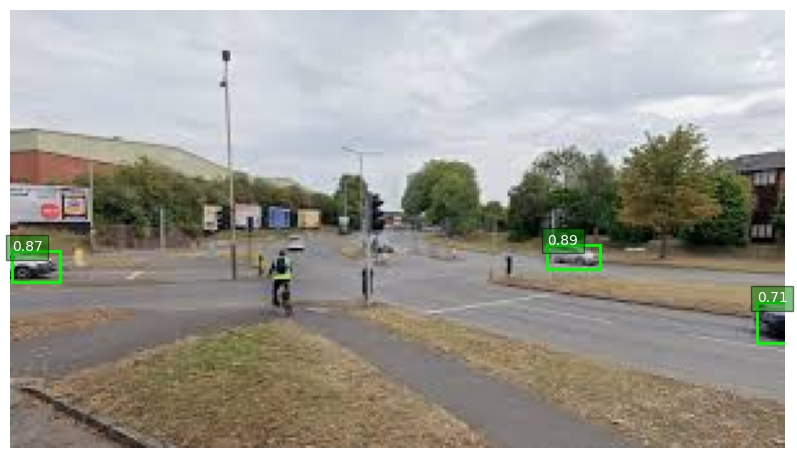

In [ ]:
predict("image3.jpeg", bucket_name, model_key = "models/car_detector.pth")

In [ ]:
!pip install torchmetrics pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 25.8 MB/s eta 0:00:00


In [ ]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torch
from tqdm import tqdm
import pandas as pd

In [ ]:
def evaluate(model, device,test_loader,object_key = "model_evaluation/map_results.csv"):
    model.eval()
    metric = MeanAveragePrecision()

    all_preds = []
    all_targets = []

    for images, targets in tqdm(test_loader):  # Replace with your actual DataLoader
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            preds = model(images)

        # Move preds and targets to CPU for torchmetrics
        preds_cpu = [{k: v.cpu() for k, v in p.items()} for p in preds]
        targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]

        metric.update(preds_cpu, targets_cpu)

    # Get mAP results
    map_results = metric.compute()

    df = pd.DataFrame(map_results.items(), columns=["Metric", "Value"])

    # Save DataFrame to in-memory CSV
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index=False)
    csv_buffer.seek(0)

    # Upload to S3
    s3 = boto3.client('s3')
    s3.put_object(Bucket=bucket_name, Key=object_key, Body=csv_buffer.getvalue())

    print(f"mAP results uploaded to s3://{bucket_name}/{object_key}")

    return map_results

In [ ]:
evaluate(model, device, test_loader)

100%|██████████| 626/626 [06:03<00:00,  1.72it/s]


mAP results uploaded to s3://cardetection01/model_evaluation/map_results.csv


{'map': tensor(0.4010),
 'map_50': tensor(0.6042),
 'map_75': tensor(0.4503),
 'map_small': tensor(0.2115),
 'map_medium': tensor(0.3345),
 'map_large': tensor(0.5300),
 'mar_1': tensor(0.2918),
 'mar_10': tensor(0.5485),
 'mar_100': tensor(0.5649),
 'mar_small': tensor(0.3871),
 'mar_medium': tensor(0.5285),
 'mar_large': tensor(0.6798),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor(1, dtype=torch.int32)}

In [ ]:
import h5py

def save_weights_to_h5(model,object_key="model_weights/model_weights.h5"):
    buffer = io.BytesIO()
    with h5py.File(buffer, 'w') as f:
        for name, param in model.named_parameters():
            f.create_dataset(name, data=param.detach().cpu().numpy())
    buffer.seek(0)
    s3 = boto3.client('s3')
    s3.upload_fileobj(buffer, bucket_name, object_key)
    print(f"Model weights uploaded to s3://{bucket_name}/{object_key}")



In [ ]:
save_weights_to_h5(model)

Model weights uploaded to s3://cardetection01/model_weights/model_weights.h5
